<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day1/Day1_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기초 시각화

포틀랜드 월간 대중교통 이용자 수 데이터와 한국 방문 관광객 수 데이터 시각화 실습을 통한 기초 시계열 시각화 실습입니다.

## 포틀랜드 월간 대중교통 이용자 수 데이터 실습

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [6]:
from urllib.parse import urljoin
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"

In [4]:
portland_tran_riders_data_path = urljoin(data_repo_url, "port_tran_riders.csv")

In [5]:
df = pd.read_csv(portland_tran_riders_data_path, parse_dates=["Month"], index_col="Month")

In [22]:
# set default style
sns.set(style="whitegrid")
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

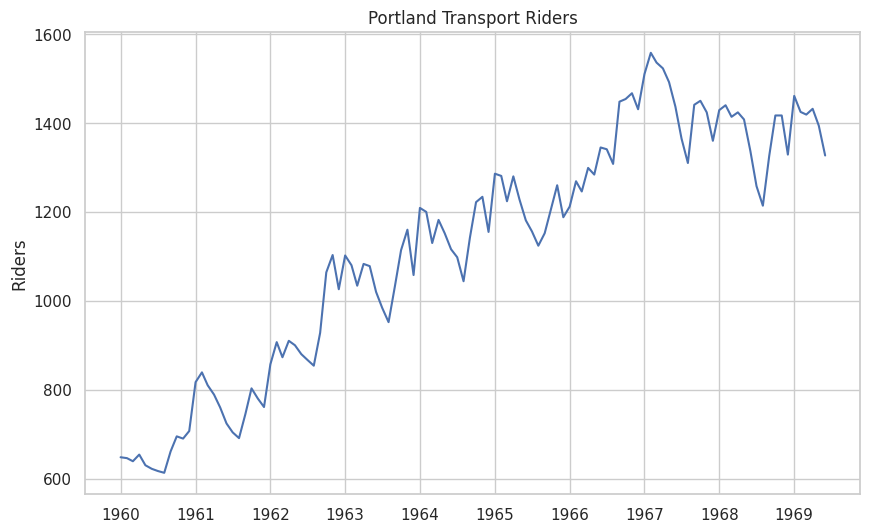

In [23]:
# 가장 기본적인 스타일
plt.figure(figsize=(10, 6))
plt.plot(df)
plt.ylabel('Riders')
plt.title('Portland Transport Riders')
plt.show()

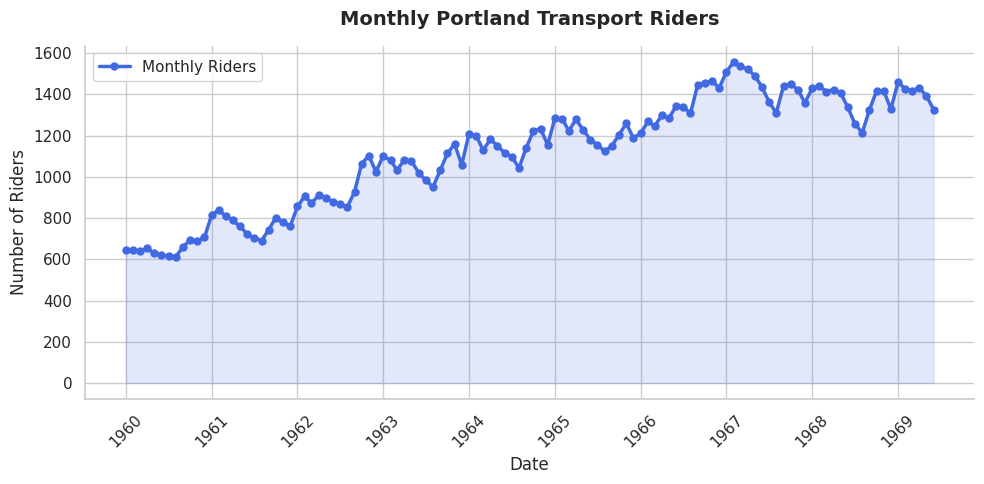

In [25]:
# 포인트 강조한 버전
fig, ax = plt.subplots(figsize=(10,5))

# marker 설정
ax.plot(df.index, df["Riders"], color="royalblue", linewidth=2.5, marker="o", markersize=5, label="Monthly Riders")
ax.fill_between(df.index, df["Riders"], color="royalblue", alpha=0.15)

# 축 및 제목 설정
ax.set_title("Monthly Portland Transport Riders", fontsize=14, pad=15, weight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Riders")

#from matplotlib.ticker import MultipleLocator
#ax.xaxis.set_major_locator(MultipleLocator(90))  # 약 분기 단위 눈금
ax.tick_params(axis="x", rotation=45)
ax.legend(frameon=True, loc="upper left")

# 시각적 강조
sns.despine()
plt.tight_layout()
plt.show()

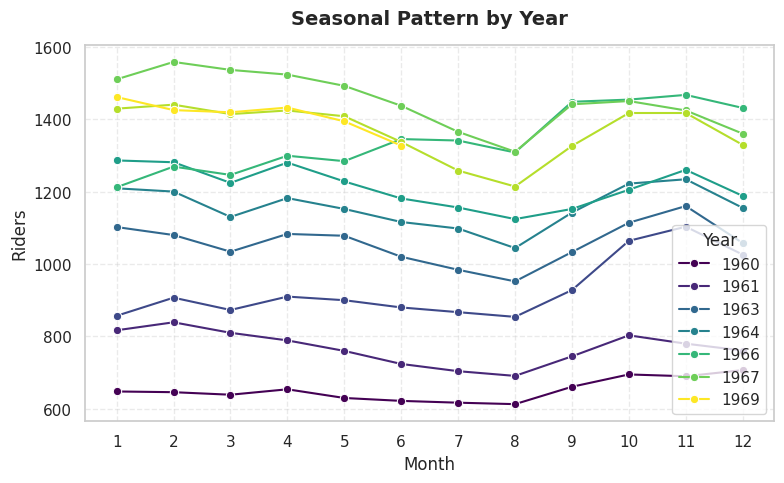

In [ ]:
# 연도별 시즌 패턴 비교
df["Year"] = df.index.year
df["Month"] = df.index.month

plt.figure(figsize=(8,5))
sns.lineplot(data=df, x="Month", y="Riders", hue="Year", palette="viridis", marker="o")
plt.title("Seasonal Pattern by Year", fontsize=14, pad=15, weight="bold")
plt.xlabel("Month")
plt.ylabel("Riders")
plt.xticks(range(1,13))
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Year")
plt.tight_layout()
plt.show()

## 방한 외국인 수 데이터 시각화

### 데이터 로드 및 전처리

In [2]:
import re

In [12]:
kor_visit_data_path = urljoin(data_repo_url, "kor_visit.csv")
kor_visit_data = pd.read_csv(kor_visit_data_path, index_col=0).T

In [14]:
print(kor_visit_data.head().to_string())

해외여행객       NaN       계  NaN
2005년01월  인원(명)  458321  NaN
2005년02월  인원(명)  477706  NaN
2005년03월  인원(명)  532397  NaN
2005년04월  인원(명)  497955  NaN
2005년05월  인원(명)  475348  NaN


In [13]:
# 값 전처리: 쉼표 제거 후 숫자형 변환
kor_visit_data['계'] = (
    kor_visit_data['계']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(int)
)

In [9]:
kor_visit_data.index = (
    kor_visit_data.index
    .to_series()
    .apply(lambda x: pd.to_datetime(re.sub(r'(\d{4})년(\d{1,2})월', r'\1-\2-01', str(x))))
)
kor_visit_data.index.name = "date"

In [33]:
kor_visit_data.index

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=180, freq=None)

In [ ]:
# 필요한 두 열만 남기기
cleaned_kor_visit = kor_visit_data[['계']].rename(columns={'계': 'total'}).sort_index()
cleaned_kor_visit.columns.name = None

In [35]:
print(cleaned_kor_visit.head().to_string())

             total
date              
2005-01-01  458321
2005-02-01  477706
2005-03-01  532397
2005-04-01  497955
2005-05-01  475348


<Axes: xlabel='date'>

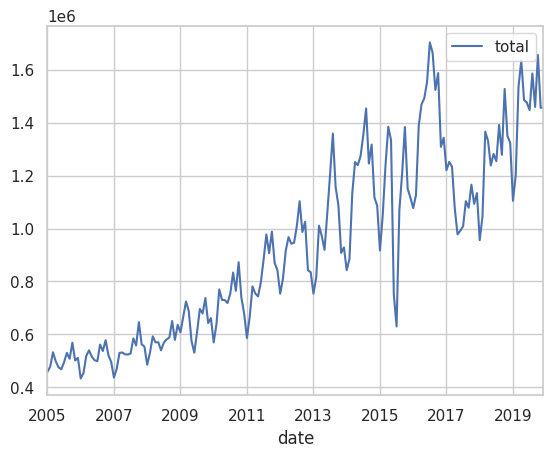

In [36]:
cleaned_kor_visit.plot()

계절성을 띄는 모습을 보이기 때문에 계절성 plot 시각화 필요!

### 계절성 강조 plot

Seasonal Subseries Plot (12개월 소패널)
- 각 패널은 특정 월의 연도별 값을 선으로 연결
- 월별 평균선을 점선으로 함께 표기
- 패널 간 비교를 위해 y축 공유
- 극단값 영향을 줄이기 위해 분위수 기반 y축 범위 사용
- 월 평균선은 옅은 점선, 평균값은 텍스트 박스로 표시
- 최근 연도 포인트를 원형 테두리로 강조

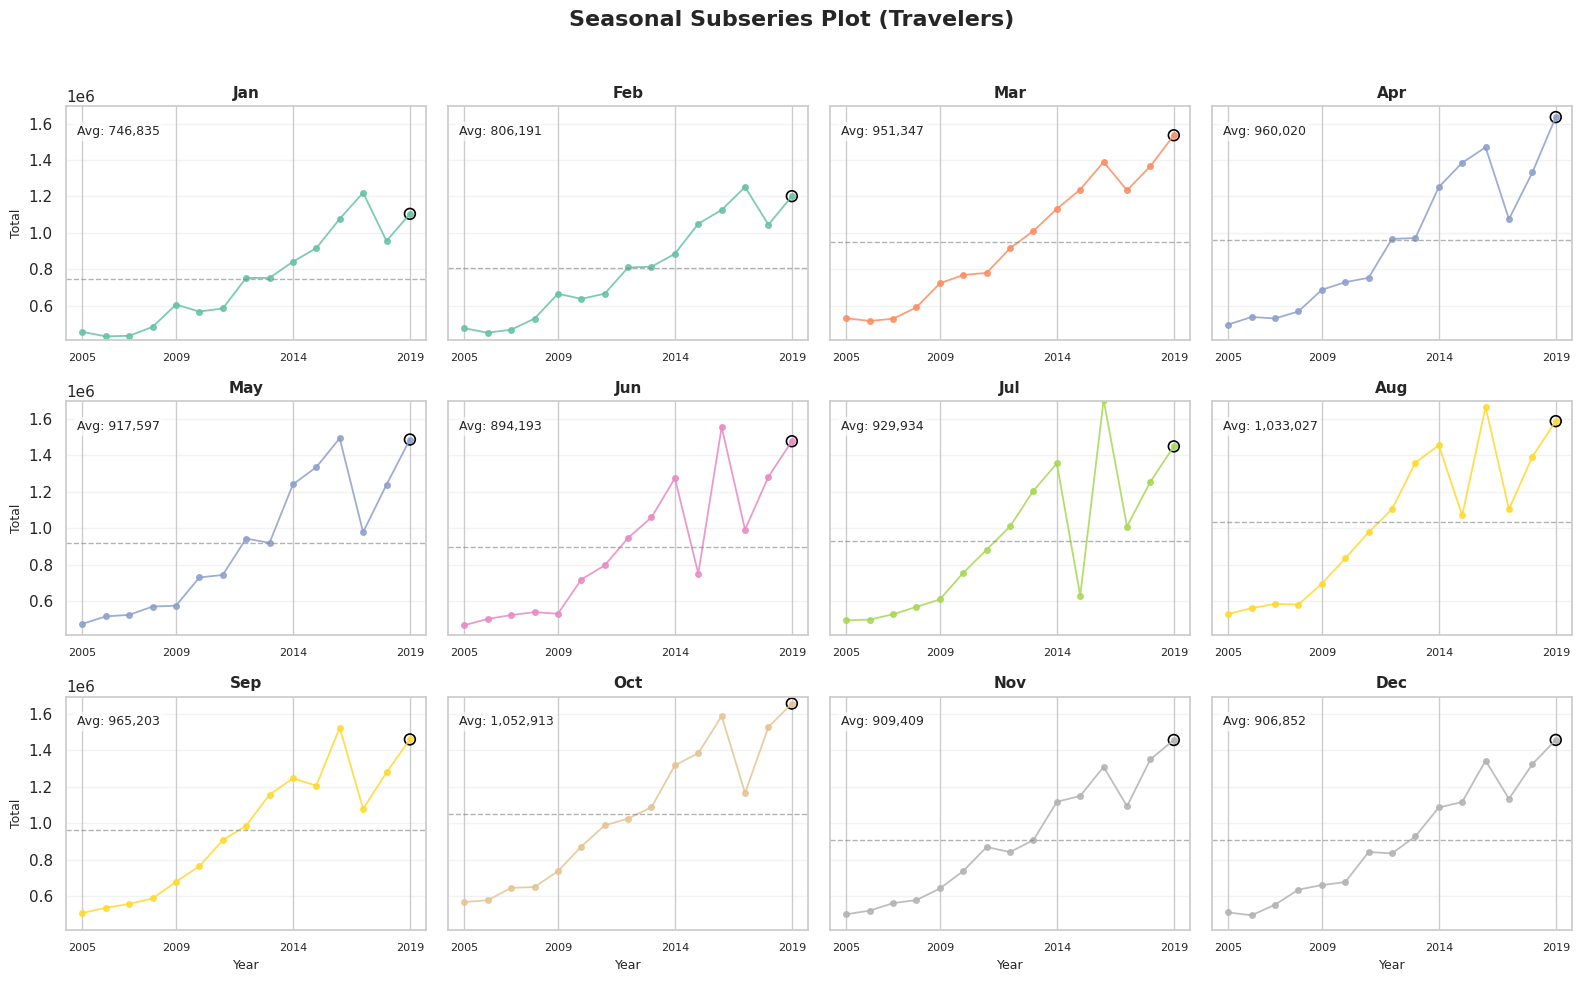

In [ ]:
# 데이터 준비: DatetimeIndex를 year, month로 분리
ss = cleaned_kor_visit.copy().sort_index()
ss["year"] = ss.index.year
ss["month"] = ss.index.month

# 전역 y축 범위를 분위수로 설정
y_q1 = ss["total"].quantile(0.01)
y_q99 = ss["total"].quantile(0.99)
y_pad = 0.03 * (y_q99 - y_q1)
ymin, ymax = y_q1 - y_pad, y_q99 + y_pad

# 최근 연도 추출
latest_year = int(ss["year"].max())

# 월 이름 및 색상 팔레트
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
palette = plt.cm.Set2(np.linspace(0, 1, 12))

fig, axes = plt.subplots(3, 4, figsize=(16, 10), sharey=True)
fig.suptitle("Seasonal Subseries Plot (Travelers)", fontsize=16, fontweight="bold")

for m in range(1, 13):
    ax = axes[(m-1)//4, (m-1)%4]
    sub = ss.loc[ss["month"] == m].sort_values("year")
    color = palette[m-1]

    # 연도별 값 라인
    ax.plot(sub["year"].values, sub["total"].values,
            marker="o", linestyle="-", linewidth=1.3, markersize=4,
            color=color, alpha=0.85)

    # 최근 연도 포인트 강조
    sub_latest = sub[sub["year"] == latest_year]
    if not sub_latest.empty:
        ax.scatter(sub_latest["year"].values, sub_latest["total"].values,
                   s=60, facecolors="none", edgecolors="black", linewidth=1.2)

    # 월 평균선과 평균값 텍스트
    m_mean = sub["total"].mean()
    ax.axhline(m_mean, color="gray", linestyle="--", linewidth=1, alpha=0.6)
    ax.text(0.03, 0.92, f"Avg: {m_mean:,.0f}", transform=ax.transAxes,
            fontsize=9, va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.65, linewidth=0))

    # 축, 그리드, 타이틀
    ax.set_title(month_labels[m-1], fontsize=11, fontweight="bold")
    ax.grid(True, axis="y", alpha=0.25)
    ax.set_ylim(ymin, ymax)

    # 연도 눈금 간소화
    if len(sub) > 0:
        years = sub["year"].unique()
        xticks = np.linspace(years.min(), years.max(), num=min(4, len(years))).astype(int)
        ax.set_xticks(xticks)
        ax.tick_params(axis="x", labelsize=8)

    # 하단 행과 좌측 열만 축 라벨 표시
    if (m-1)//4 == 2:
        ax.set_xlabel("Year", fontsize=9)
    if (m-1)%4 == 0:
        ax.set_ylabel("Total", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### (추가 실습)

계절별 Subseries Plot 그리기

- 월별 Subseries Plot을 계절별 Subseries Plot으로 변환
- groupby("year")["total"].mean()을 활용해 연도별 계절 평균값 계산
- 이 평균값을 이용해 각 계절별 연도별 평균 추세선 그리기

# 금융 데이터 시각화 예시


Bitcoin, Gold, MSFT, NVDA, S&P500의 최근 10년치 데이터를 활용하여 시각화 실습을 진행하겠습니다.

In [16]:
bitcoin = pd.read_csv(urljoin(data_repo_url, 'bitcoin.csv'), parse_dates=['Date'])
gold = pd.read_csv(urljoin(data_repo_url, 'gold.csv'), parse_dates=['Date'])
msft = pd.read_csv(urljoin(data_repo_url, 'msft.csv'), parse_dates=['Date'])
nvda = pd.read_csv(urljoin(data_repo_url, 'nvda.csv'), parse_dates=['Date'])
snp500 = pd.read_csv(urljoin(data_repo_url, 'snp500.csv'), parse_dates=['Date'])

# Date를 인덱스로 설정
bitcoin.set_index('Date', inplace=True)
gold.set_index('Date', inplace=True)
msft.set_index('Date', inplace=True)
nvda.set_index('Date', inplace=True)
snp500.set_index('Date', inplace=True)

## 이중 축 가격 비교 (Dual Axis Price Comparison)

서로 다른 스케일의 자산을 원본 가격으로 비교할 때는 이중 축 사용합니다. Bitcoin, S&P500 예시를 통해 확인해보겠습니다.


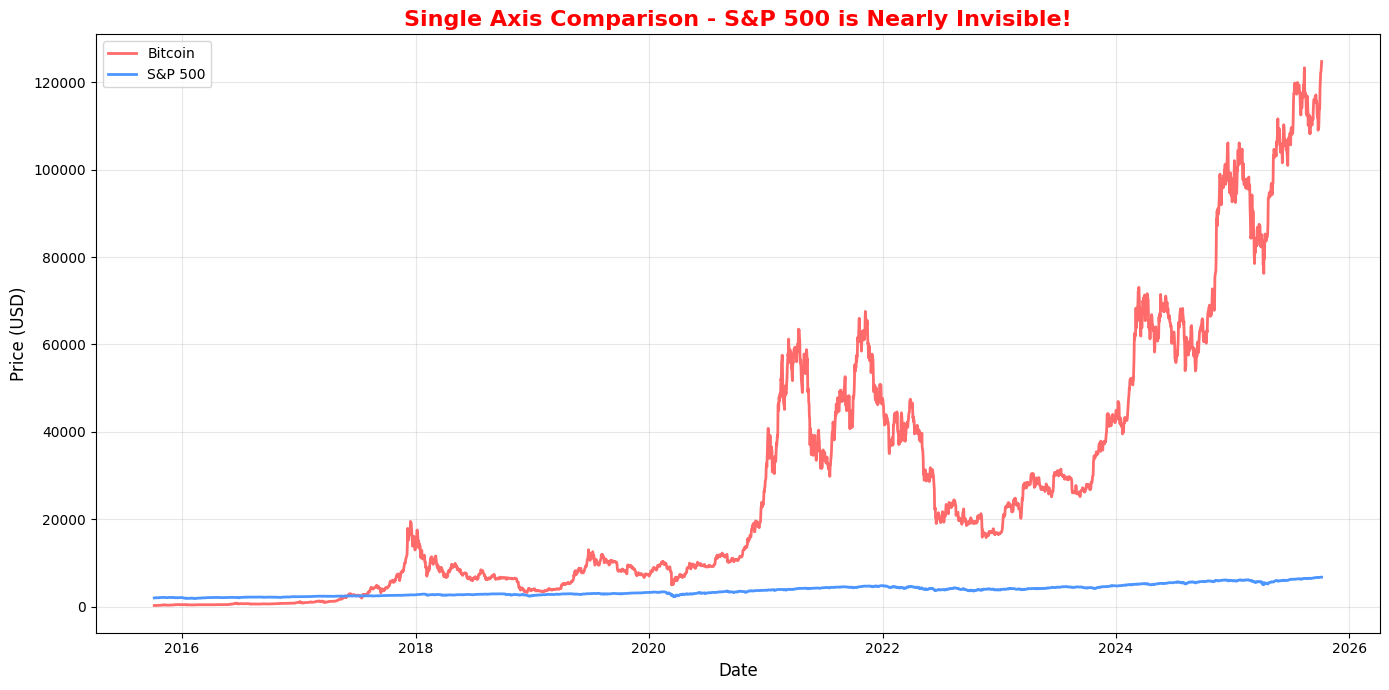

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(bitcoin.index, bitcoin['Adj Close'], label='Bitcoin', linewidth=2, color='#FF6B6B')
plt.plot(snp500.index, snp500['Adj Close'], label='S&P 500', linewidth=2, color='#4D96FF')
plt.title('Single Axis Comparison - S&P 500 is Nearly Invisible!', fontsize=16, fontweight='bold', color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

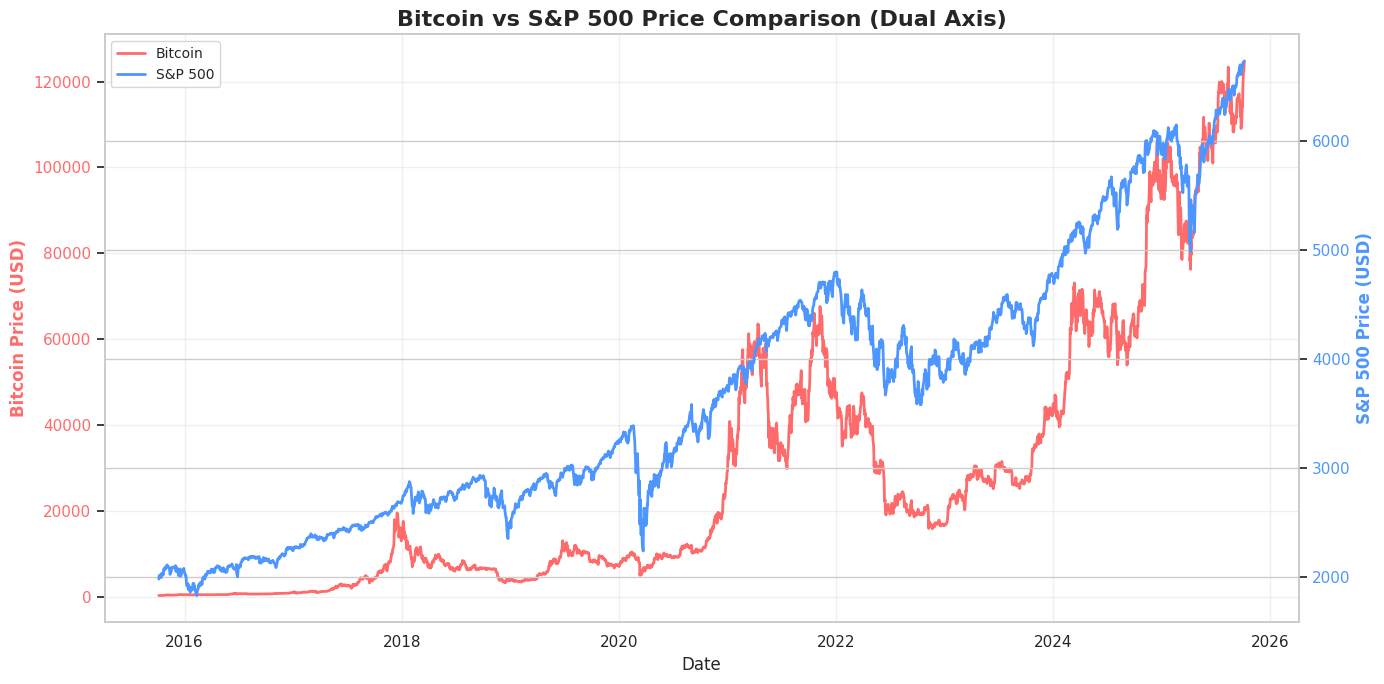

In [49]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# 왼쪽 축: Bitcoin
color1 = '#FF6B6B'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Bitcoin Price (USD)', color=color1, fontsize=12, fontweight='bold')
ax1.plot(bitcoin.index, bitcoin['Adj Close'], color=color1, linewidth=2, label='Bitcoin')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# 오른쪽 축: S&P 500
ax2 = ax1.twinx()
color2 = '#4D96FF'
ax2.set_ylabel('S&P 500 Price (USD)', color=color2, fontsize=12, fontweight='bold')
ax2.plot(snp500.index, snp500['Adj Close'], color=color2, linewidth=2, label='S&P 500')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Bitcoin vs S&P 500 Price Comparison (Dual Axis)', fontsize=16, fontweight='bold')

# 범례 결합
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

## 연간 수익률 히트맵 (Annual Returns Heatmap)

히트맵으로 각 자산의 연도별 성과를 한눈에 비교 가능합니다.

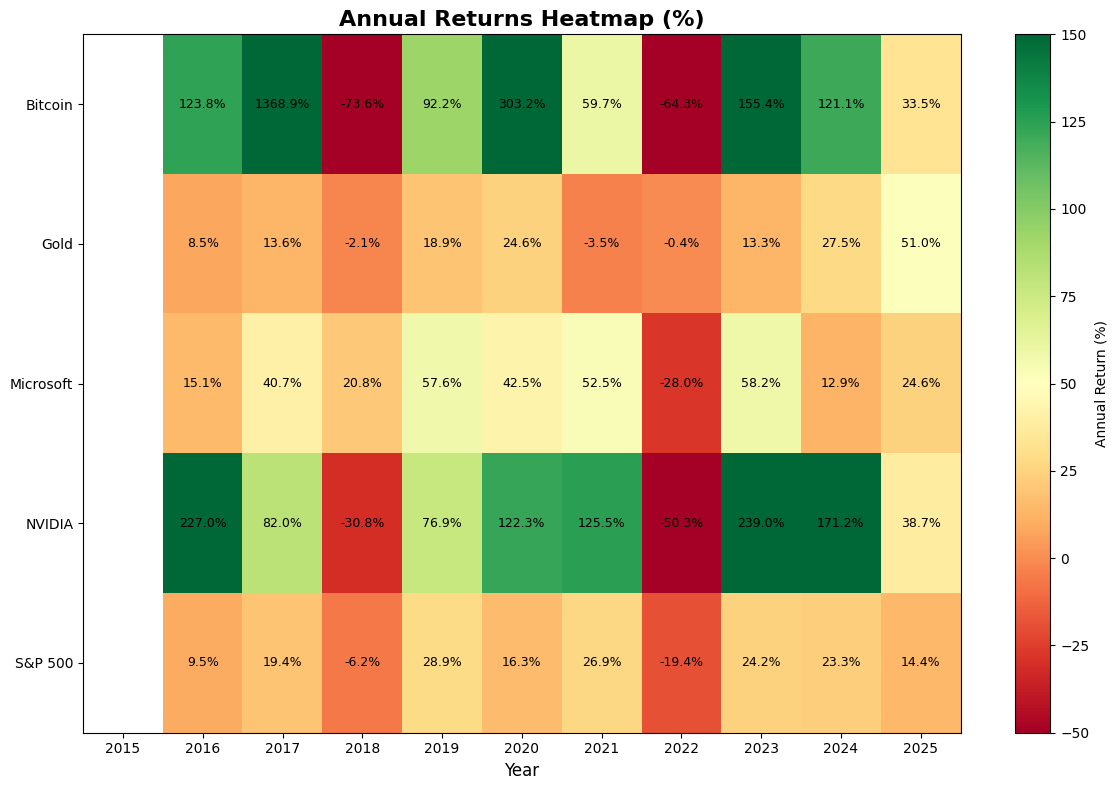

In [18]:
# 히트맵을 위해 스타일 임시 해제
plt.style.use('default')

# 연간 수익률 계산 함수
def calculate_annual_returns(df):
    df_yearly = df['Adj Close'].resample('YE').last()
    returns = df_yearly.pct_change() * 100
    return returns

# 각 자산의 연간 수익률 계산
returns_data = {
    'Bitcoin': calculate_annual_returns(bitcoin),
    'Gold': calculate_annual_returns(gold),
    'Microsoft': calculate_annual_returns(msft),
    'NVIDIA': calculate_annual_returns(nvda),
    'S&P 500': calculate_annual_returns(snp500)
}

returns_df = pd.DataFrame(returns_data)
returns_df.index = returns_df.index.year

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(returns_df.T, cmap='RdYlGn', aspect='auto', vmin=-50, vmax=150)

# 축 설정
ax.set_xticks(np.arange(len(returns_df.index)))
ax.set_yticks(np.arange(len(returns_df.columns)))
ax.set_xticklabels(returns_df.index)
ax.set_yticklabels(returns_df.columns)

# 각 셀에 수치 표시
for i in range(len(returns_df.columns)):
    for j in range(len(returns_df.index)):
        value = returns_df.iloc[j, i]
        if not np.isnan(value):
            text = ax.text(j, i, f'{value:.1f}%',
                          ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax, label='Annual Return (%)')
plt.title('Annual Returns Heatmap (%)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

sns.set(style="whitegrid")

## 리스크-리턴 산점도 (Risk-Return Scatter Plot)

변동성(위험) 대비 수익률을 비교하여 투자 효율성 평가

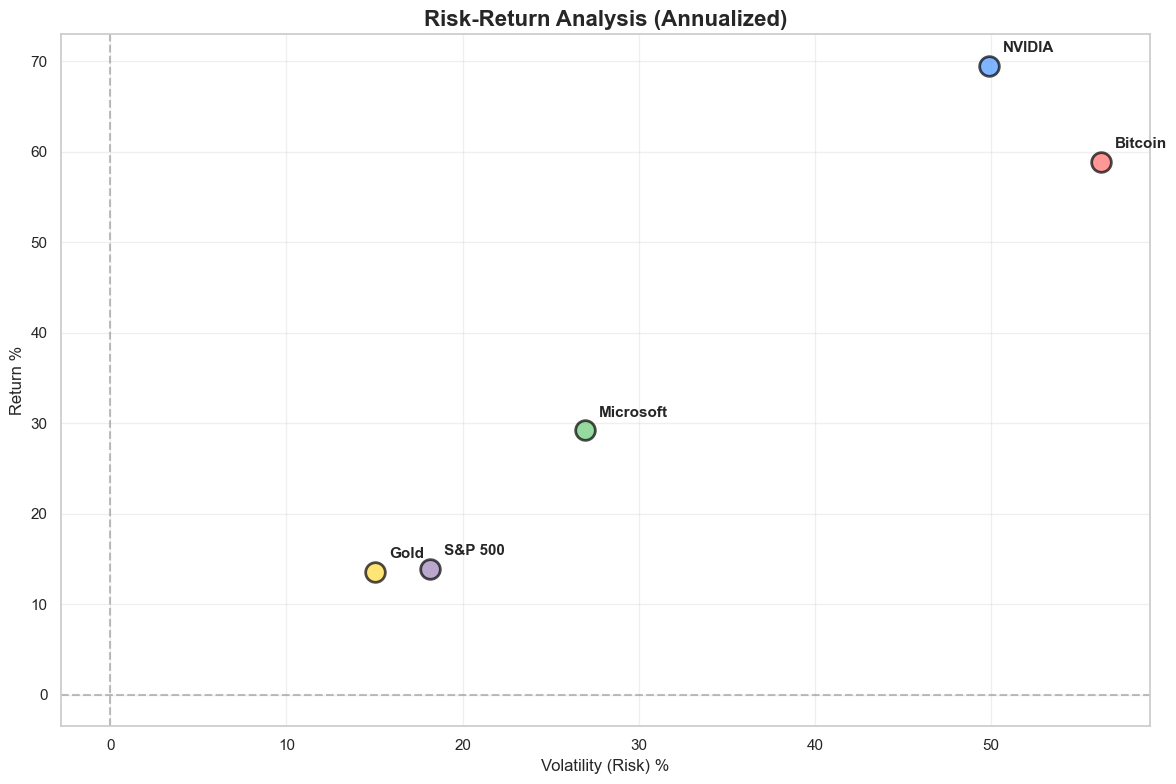

In [52]:
# 일간 수익률 계산
daily_returns = pd.DataFrame({
    'Bitcoin': bitcoin['Adj Close'].pct_change(),
    'Gold': gold['Adj Close'].pct_change(),
    'Microsoft': msft['Adj Close'].pct_change(),
    'NVIDIA': nvda['Adj Close'].pct_change(),
    'S&P 500': snp500['Adj Close'].pct_change()
})

# 연율화된 수익률과 변동성 계산
annual_return = daily_returns.mean() * 252 * 100  # 252 trading days
annual_volatility = daily_returns.std() * np.sqrt(252) * 100

plt.figure(figsize=(12, 8))

colors = ['#FF6B6B', '#FFD93D', '#6BCB77', '#4D96FF', '#9D84B7']
for i, asset in enumerate(annual_return.index):
    plt.scatter(annual_volatility[asset], annual_return[asset],
               s=200, alpha=0.7, c=colors[i], edgecolors='black', linewidth=2)
    plt.annotate(asset, (annual_volatility[asset], annual_return[asset]),
                xytext=(10, 10), textcoords='offset points', fontsize=11, fontweight='bold')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.title('Risk-Return Analysis (Annualized)', fontsize=16, fontweight='bold')
plt.xlabel('Volatility (Risk) %', fontsize=12)
plt.ylabel('Return %', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 제조업 관련 지수 데이터를 활용한 시각화 실습

FRED(Federal Reserve Economic Data)의 실제 제조업 데이터를 활용하여 시계열 시각화 기법을 학습해 보겠습니다.

1. **IPMAN (제조업 생산지수, Industrial Production: Manufacturing)**
   - 의미: 미국 제조업 전체의 실질 생산량을 나타내는 지수
   - 기준: 2017년 = 100
   - 특징: 계절성이 뚜렷함 (연말 생산 증가, 여름 휴가철 감소 등)
   - 갱신: 월별 (매월 15일경 발표)
   - 용도: 경기 판단, 제조업 경기 예측, GDP 예측 등에 활용
   - `manufacturing_index` column에 저장

2. **IPG3366S (선박 및 보트 제조업 생산지수, Ship and Boat Building)**
   - 의미: 조선업(선박, 보트, 관련 부품) 생산량 지수
   - 기준: 2017년 = 100
   - 특징: 계절성 + 대규모 주문에 따른 변동성이 큼
   - NAICS 코드: 3366 (선박 및 보트 제조)
   - 용도: 조선업 경기 분석, 해운업 수요 예측
   - `shipbuilding_index` column에 저장

3. **CUMFNS (제조업 용량 가동률, Capacity Utilization: Manufacturing)**
   - 의미: 제조업 설비의 실제 가동률 (%)
   - 범위: 0-100% (보통 75-85% 수준)
   - 특징: 경기 민감 지표 (호황기 증가, 불황기 감소)
   - 용도: 인플레이션 압력 예측, 설비투자 필요성 판단
   - `capacity_utilization` column에 저장

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [55]:
manufacturing_data_path= urljoin(data_repo_url, "manufacturing_shipping_data_fred.csv")

In [57]:
df = pd.read_csv(manufacturing_data_path, index_col=0, parse_dates=True)

In [59]:
df.head()

,manufacturing_index,shipbuilding_index,capacity_utilization
DATE,,,
2010-01-01,89.5484,91.9641,67.7946
2010-02-01,89.5698,92.8010,67.8466
2010-03-01,90.7779,95.2921,68.8106
2010-04-01,91.5998,94.4432,69.4860
2010-05-01,92.8159,96.8578,70.4982


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 2010-01-01 to 2025-08-01
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   manufacturing_index   188 non-null    float64
 1   shipbuilding_index    188 non-null    float64
 2   capacity_utilization  188 non-null    float64
dtypes: float64(3)
memory usage: 5.9 KB


In [61]:
df.describe()

,manufacturing_index,shipbuilding_index,capacity_utilization
count,188.000000,188.000000,188.000000
mean,98.527909,101.990889,75.859457
std,3.058084,8.523771,2.613797
min,79.956400,79.196600,62.315800
25%,98.159525,97.419300,74.734150
50%,99.419750,101.319000,76.324600
75%,100.235525,107.462625,77.435275
max,102.019500,119.452000,80.055900


In [62]:
print(f"  기간: {df.index[0].strftime('%Y-%m-%d')} ~ {df.index[-1].strftime('%Y-%m-%d')}")
print(f"  총 관측치: {len(df)}개")

  기간: 2010-01-01 ~ 2025-08-01
  총 관측치: 188개


In [63]:
df['year'] = df.index.year
df['month'] = df.index.month

In [64]:
df.head()

,manufacturing_index,shipbuilding_index,capacity_utilization,year,month
DATE,,,,,
2010-01-01,89.5484,91.9641,67.7946,2010,1
2010-02-01,89.5698,92.8010,67.8466,2010,2
2010-03-01,90.7779,95.2921,68.8106,2010,3
2010-04-01,91.5998,94.4432,69.4860,2010,4
2010-05-01,92.8159,96.8578,70.4982,2010,5


## 기본 시계열 플롯

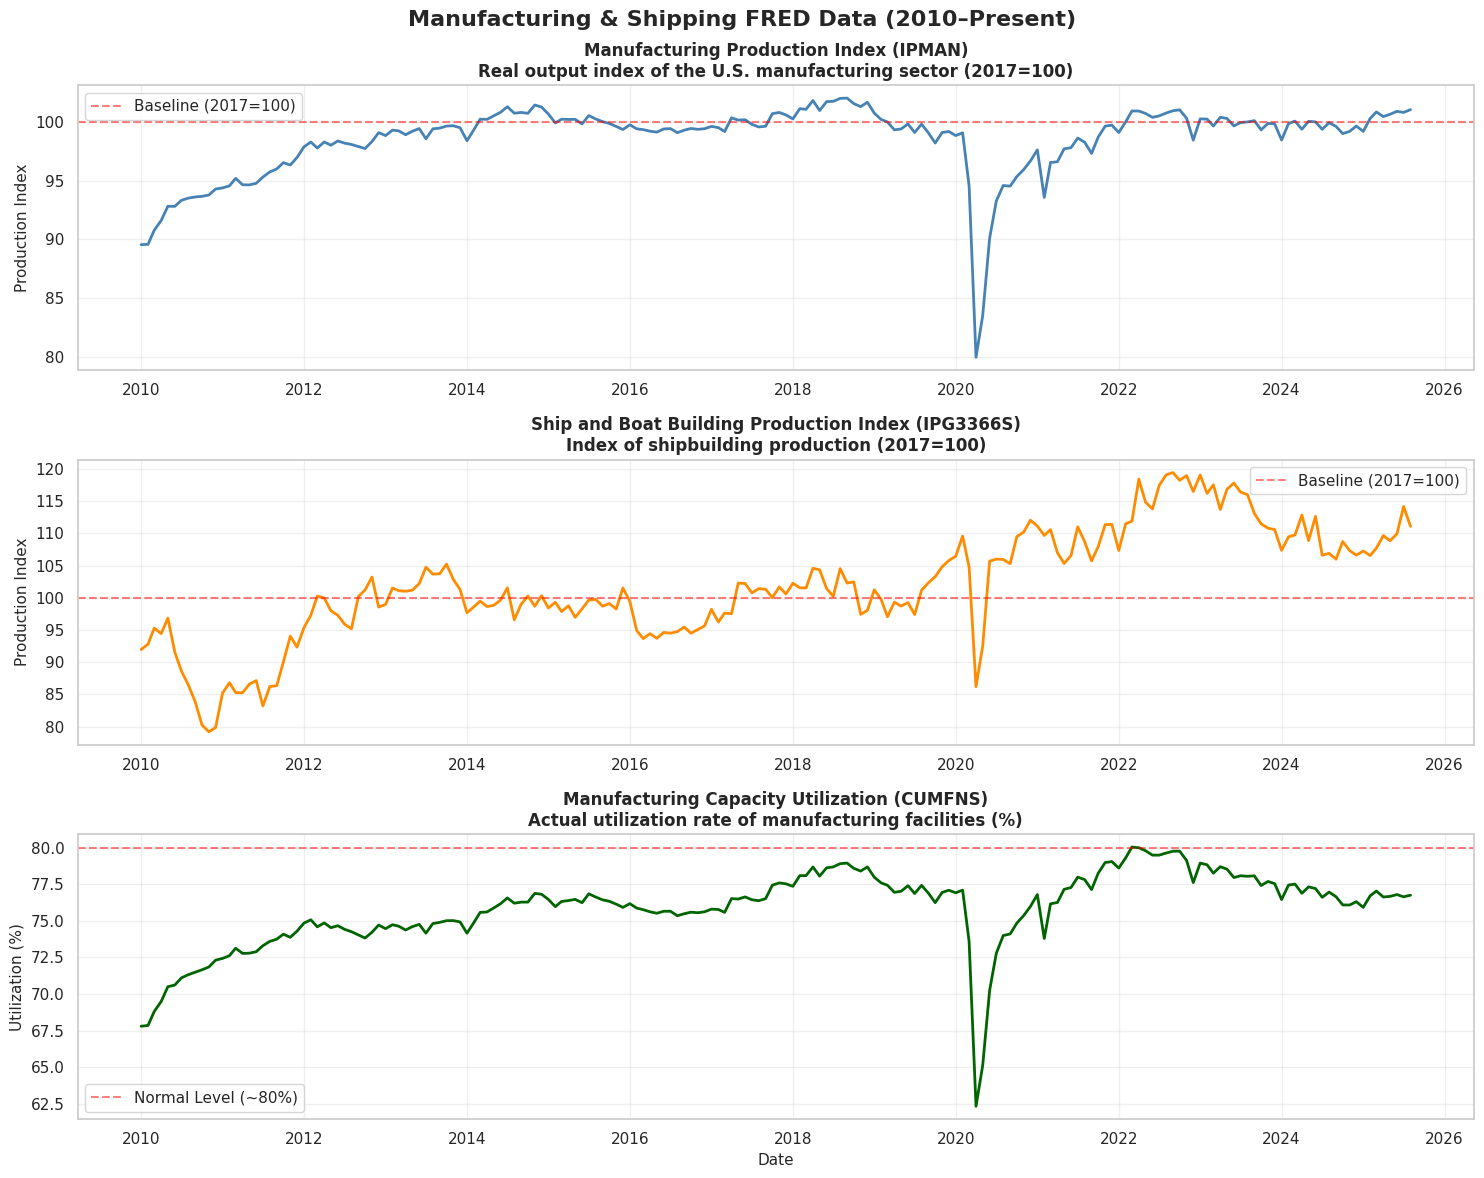

In [32]:
# 기간에 따른 변화 시각화
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Manufacturing & Shipping FRED Data (2010–Present)', fontsize=16, fontweight='bold')

# 제조업 생산지수 (Manufacturing Production Index)
axes[0].plot(df.index, df['manufacturing_index'], linewidth=2, color='steelblue')
axes[0].set_title('Manufacturing Production Index (IPMAN)\nReal output index of the U.S. manufacturing sector (2017=100)',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Production Index', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Baseline (2017=100)')
axes[0].legend()

# 조선업 생산지수 (Shipbuilding Production Index)
axes[1].plot(df.index, df['shipbuilding_index'], linewidth=2, color='darkorange')
axes[1].set_title('Ship and Boat Building Production Index (IPG3366S)\nIndex of shipbuilding production (2017=100)',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Production Index', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Baseline (2017=100)')
axes[1].legend()

# 제조업 용량 가동률 (Capacity Utilization in Manufacturing)
axes[2].plot(df.index, df['capacity_utilization'], linewidth=2, color='darkgreen')
axes[2].set_title('Manufacturing Capacity Utilization (CUMFNS)\nActual utilization rate of manufacturing facilities (%)',
                  fontsize=12, fontweight='bold')
axes[2].set_ylabel('Utilization (%)', fontsize=11)
axes[2].set_xlabel('Date', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=80, color='red', linestyle='--', alpha=0.5, label='Normal Level (~80%)')
axes[2].legend()

plt.tight_layout()
plt.show()


## Seasonal Subseries Plot - 제조업 생산지수

**해석 방법:**
- 각 월의 시계열을 개별적으로 표시
- 빨간 점선: 해당 월의 평균값

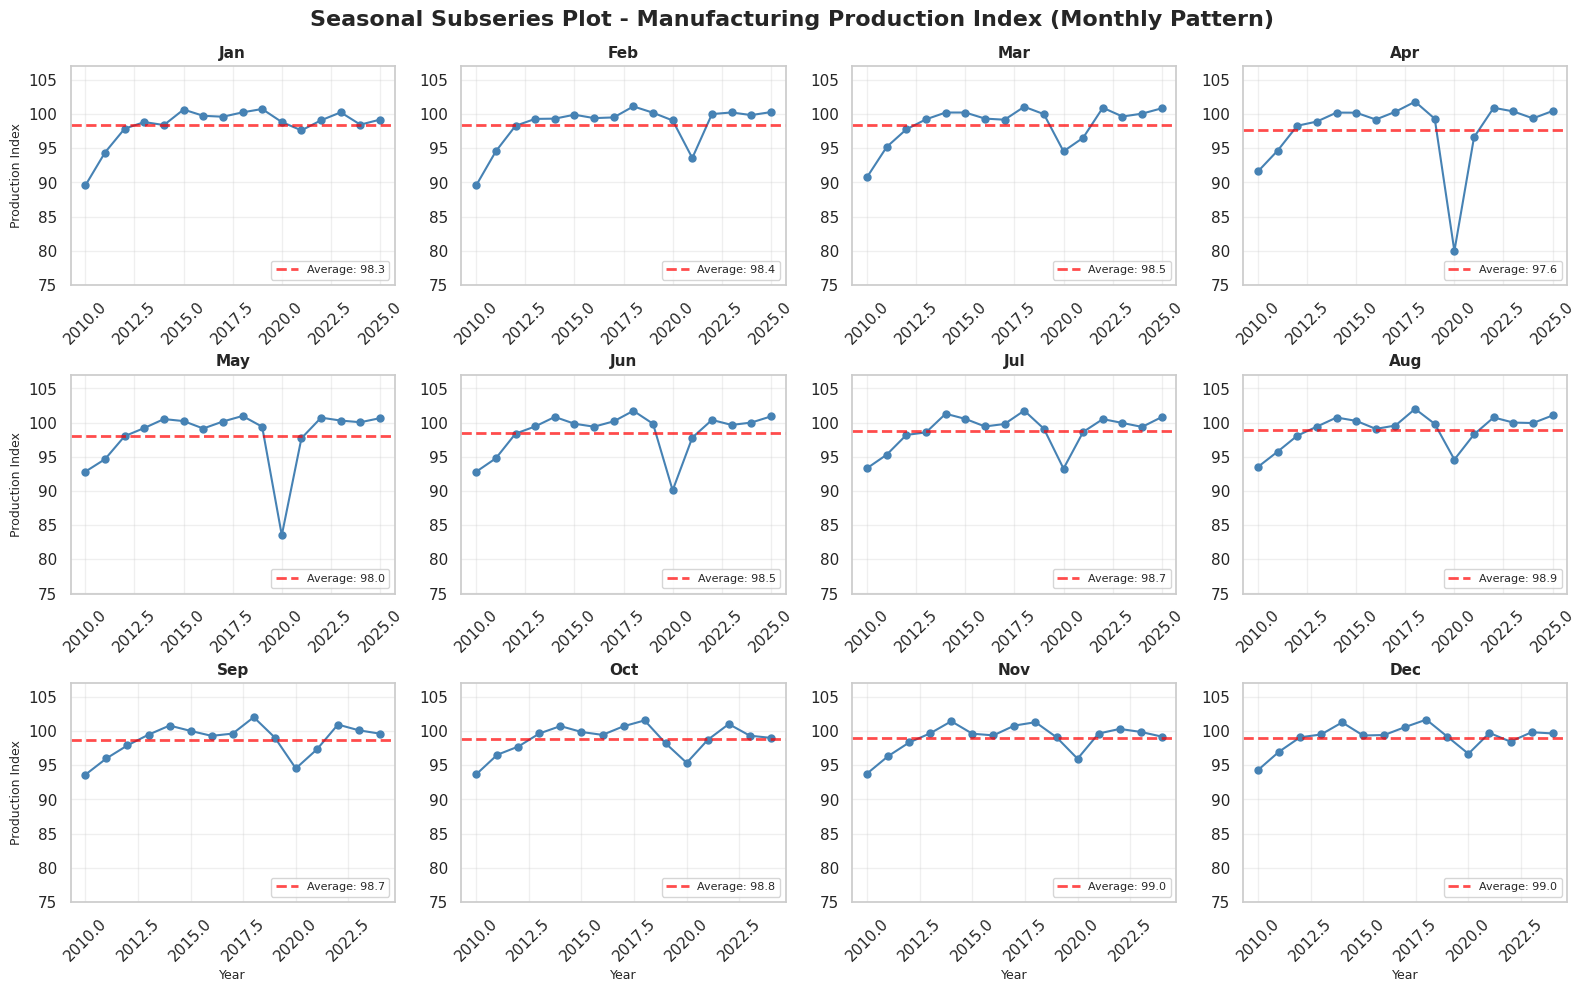

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle('Seasonal Subseries Plot - Manufacturing Production Index (Monthly Pattern)',
             fontsize=16, fontweight='bold')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, (ax, month_num) in enumerate(zip(axes.flat, range(1, 13))):
    month_data = df[df['month'] == month_num]

    # 각 연도의 해당 월 데이터 플롯
    ax.plot(month_data['year'], month_data['manufacturing_index'],
            marker='o', linestyle='-', linewidth=1.5, markersize=5, color='steelblue')

    # 월별 평균선
    mean_val = month_data['manufacturing_index'].mean()
    ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=2, alpha=0.7,
               label=f'Average: {mean_val:.1f}')

    ax.set_title(f'{months[i]}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='lower right')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim([df['manufacturing_index'].min() - 5, df['manufacturing_index'].max() + 5])

    if i >= 8:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('Production Index', fontsize=9)

plt.tight_layout()
plt.show()


In [34]:
# 월별 평균 계산 및 출력
monthly_avg = df.groupby('month')['manufacturing_index'].mean()
print("\n=== 월별 평균 제조업 생산지수 ===")
for month_num, avg in monthly_avg.items():
    print(f"{months[month_num-1]}: {avg:.2f}")

print("\n**해석:**")
print(f"- 가장 높은 달: {months[monthly_avg.idxmax()-1]} ({monthly_avg.max():.2f})")
print(f"- 가장 낮은 달: {months[monthly_avg.idxmin()-1]} ({monthly_avg.min():.2f})")
print(f"- 계절성 강도: {monthly_avg.max() - monthly_avg.min():.2f} 포인트 차이")


=== 월별 평균 제조업 생산지수 ===
Jan: 98.34
Feb: 98.38
Mar: 98.47
Apr: 97.64
May: 97.99
Jun: 98.49
Jul: 98.73
Aug: 98.92
Sep: 98.68
Oct: 98.76
Nov: 98.97
Dec: 99.04

**해석:**
- 가장 높은 달: Dec (99.04)
- 가장 낮은 달: Apr (97.64)
- 계절성 강도: 1.40 포인트 차이


## Scatter Plot - 변수 간 관계 분석

**분석 목적:**
- 제조업 생산지수와 조선업 생산지수의 관계
- 제조업 생산지수와 용량 가동률의 관계

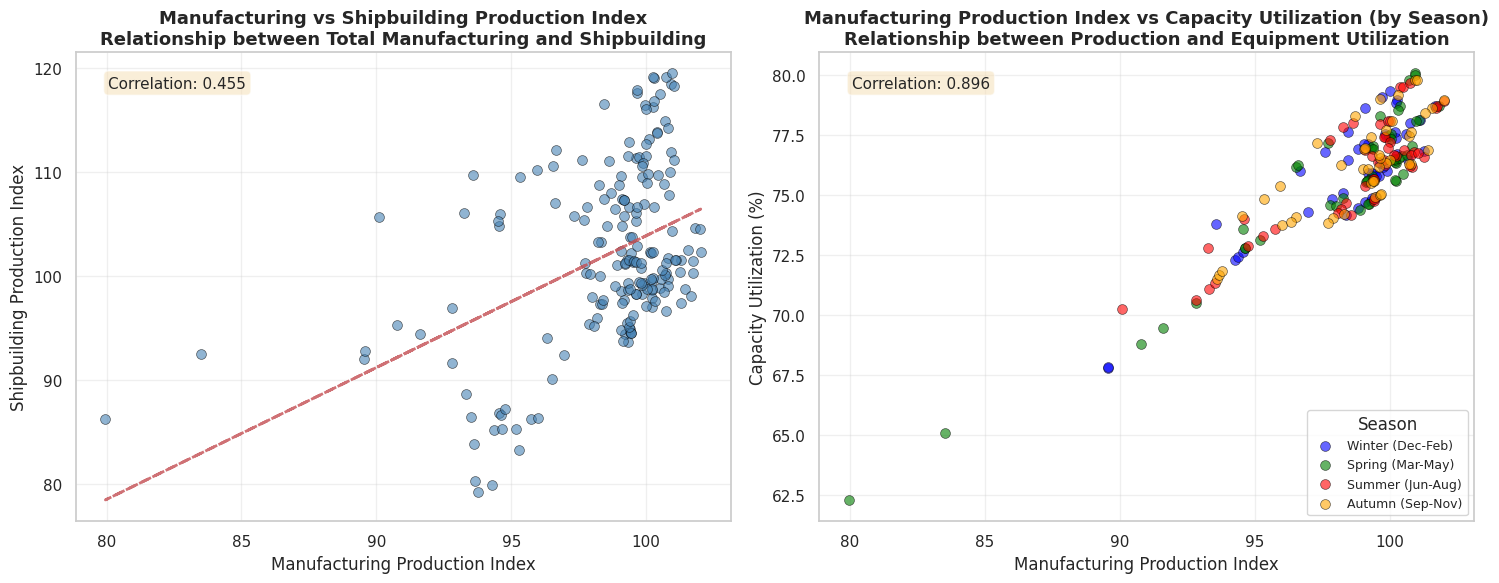

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# [좌측] 제조업 vs 조선업
axes[0].scatter(df['manufacturing_index'], df['shipbuilding_index'],
                alpha=0.6, s=50, color='steelblue', edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Manufacturing Production Index', fontsize=12)
axes[0].set_ylabel('Shipbuilding Production Index', fontsize=12)
axes[0].set_title('Manufacturing vs Shipbuilding Production Index\nRelationship between Total Manufacturing and Shipbuilding',
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 추세선 (1차 다항식 회귀선)
z1 = np.polyfit(df['manufacturing_index'], df['shipbuilding_index'], 1)
p1 = np.poly1d(z1)
axes[0].plot(df['manufacturing_index'], p1(df['manufacturing_index']),
             "r--", linewidth=2, alpha=0.8)

# 상관계수 (두 변수 간의 선형 관계 강도)
corr1 = df['manufacturing_index'].corr(df['shipbuilding_index'])
axes[0].text(0.05, 0.95, f'Correlation: {corr1:.3f}',
             transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# [우측] 제조업 생산지수 vs 용량 가동률 (계절별 색상 구분)
df['season'] = df['month'].map({12:1, 1:1, 2:1,  # 겨울
                                 3:2, 4:2, 5:2,   # 봄
                                 6:3, 7:3, 8:3,   # 여름
                                 9:4, 10:4, 11:4}) # 가을

colors = {1: 'blue', 2: 'green', 3: 'red', 4: 'orange'}
labels = {1: 'Winter (Dec-Feb)', 2: 'Spring (Mar-May)', 3: 'Summer (Jun-Aug)', 4: 'Autumn (Sep-Nov)'}

# 계절별 산점도
for season in [1, 2, 3, 4]:
    season_data = df[df['season'] == season]
    axes[1].scatter(season_data['manufacturing_index'], season_data['capacity_utilization'],
                   alpha=0.6, s=50, color=colors[season], label=labels[season],
                   edgecolors='black', linewidth=0.5)

axes[1].set_xlabel('Manufacturing Production Index', fontsize=12)
axes[1].set_ylabel('Capacity Utilization (%)', fontsize=12)
axes[1].set_title('Manufacturing Production Index vs Capacity Utilization (by Season)\nRelationship between Production and Equipment Utilization',
                  fontsize=13, fontweight='bold')
axes[1].legend(title='Season', fontsize=9)
axes[1].grid(True, alpha=0.3)

# 상관계수 (전체 데이터 기준)
corr2 = df['manufacturing_index'].corr(df['capacity_utilization'])
axes[1].text(0.05, 0.95, f'Correlation: {corr2:.3f}',
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [36]:
correlation_matrix = df[['manufacturing_index', 'shipbuilding_index', 'capacity_utilization']].corr()

In [37]:
correlation_matrix

,manufacturing_index,shipbuilding_index,capacity_utilization
manufacturing_index,1.000000,0.454776,0.895737
shipbuilding_index,0.454776,1.000000,0.661745
capacity_utilization,0.895737,0.661745,1.000000


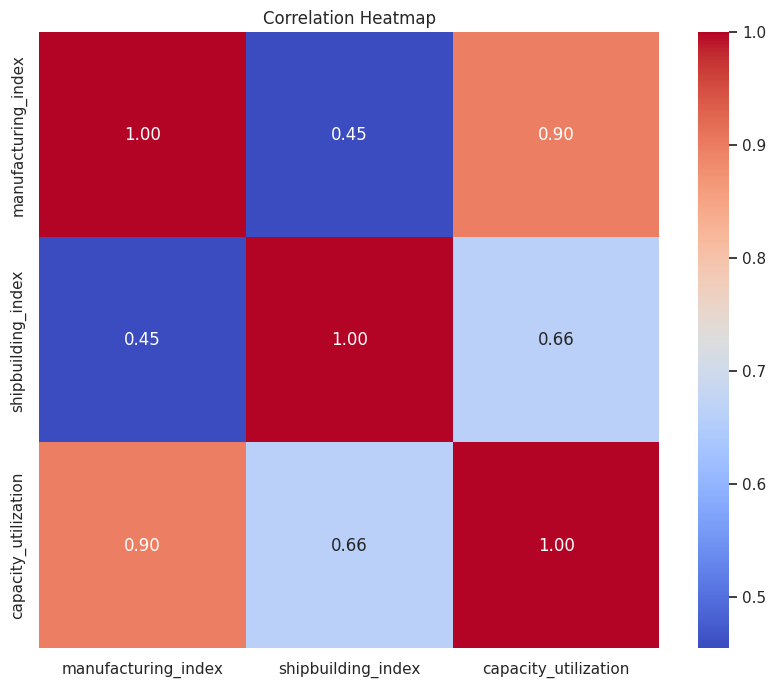

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [39]:
print("\n=== 상관관계 분석 ===")
print(f"제조업 vs 조선업: {corr1:.3f} (약한 {'양' if corr1 > 0 else '음'}의 상관)")
print(f"제조업 vs 용량가동률: {corr2:.3f} ({'강한' if abs(corr2) > 0.7 else '중간' if abs(corr2) > 0.4 else '약한'} {'양' if corr2 > 0 else '음'}의 상관)")


=== 상관관계 분석 ===
제조업 vs 조선업: 0.455 (약한 양의 상관)
제조업 vs 용량가동률: 0.896 (강한 양의 상관)


## Lag Plot - 자기상관 시각화

**해석 방법:**
- Lag 1: 1개월 전 값과의 관계 (단기 자기상관)
- Lag 3: 3개월 전 값과의 관계 (분기별 패턴)
- Lag 6: 6개월 전 값과의 관계 (반년 주기)
- Lag 12: 12개월 전 값과의 관계 (계절성)

**패턴 읽기:**
- 대각선 근처에 모임: 강한 자기상관 (과거와 유사한 패턴)
- 색상별 군집: 계절성이 강할 때 나타남

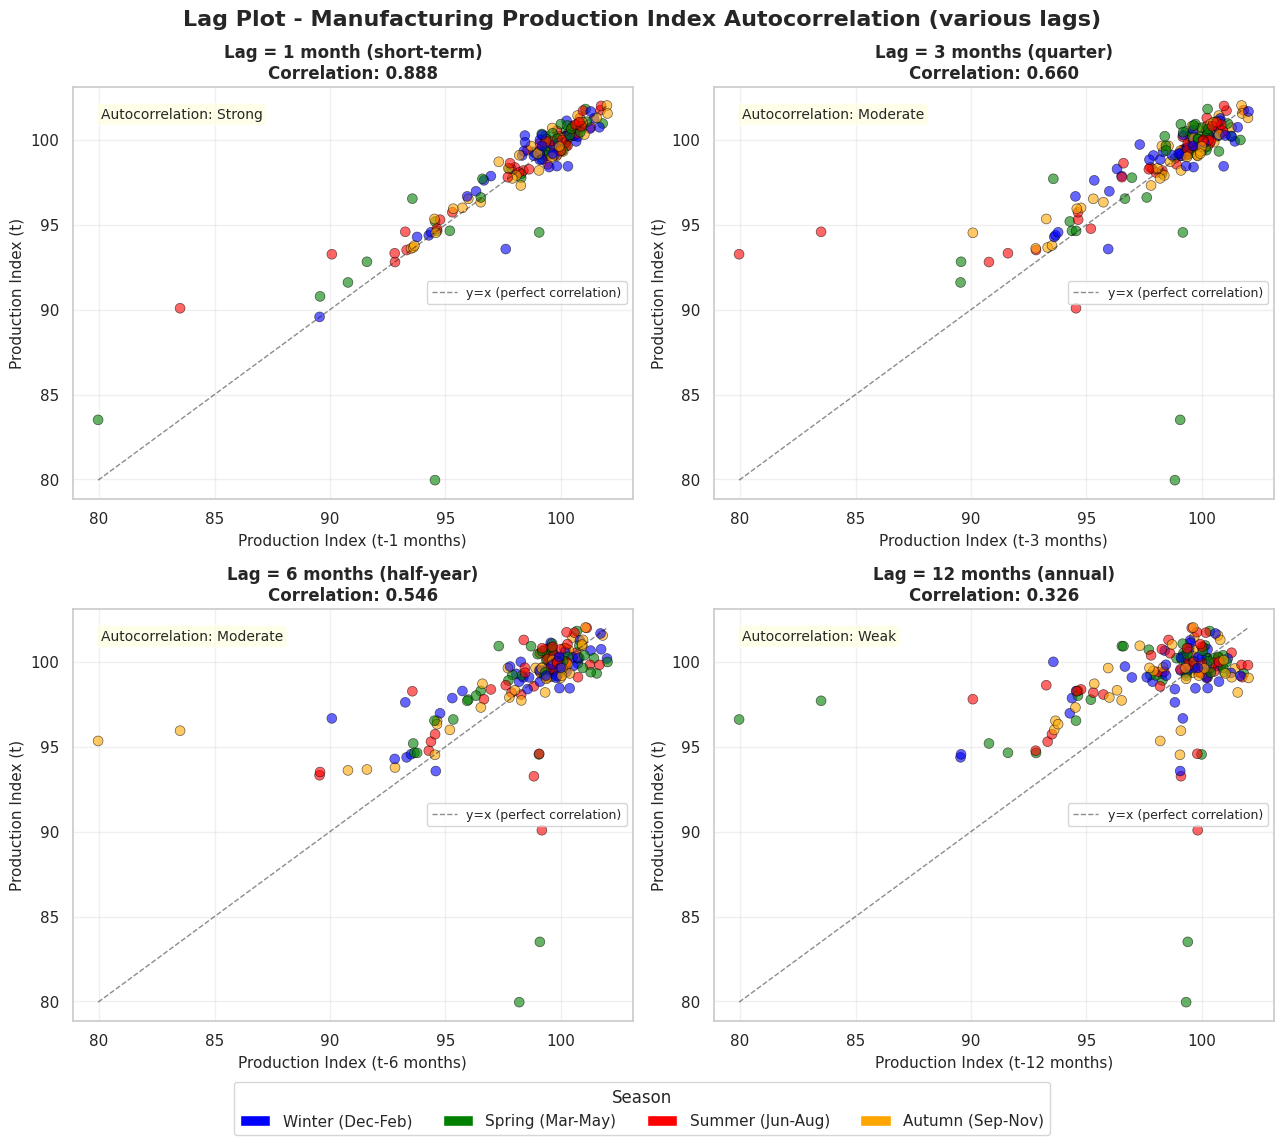

In [40]:
lags = [1, 3, 6, 12]
fig, axes = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Lag Plot - Manufacturing Production Index Autocorrelation (various lags)',
             fontsize=16, fontweight='bold')

# 시차 이름 사전 (표기용)
lag_names = {1: '1 month (short-term)', 3: '3 months (quarter)', 6: '6 months (half-year)', 12: '12 months (annual)'}

for ax, lag in zip(axes.flat, lags):
    lagged_data = df['manufacturing_index'].shift(lag)

    # 계절별 색상 매핑
    colors_map = df['season'].map(colors)

    scatter = ax.scatter(lagged_data, df['manufacturing_index'],
                         alpha=0.6, s=50, c=colors_map, edgecolors='black', linewidth=0.5)

    # 대각선 참조선 (y=x)
    min_val = min(lagged_data.min(), df['manufacturing_index'].min())
    max_val = max(lagged_data.max(), df['manufacturing_index'].max())
    ax.plot([min_val, max_val], [min_val, max_val],
            'k--', linewidth=1, alpha=0.5, label='y=x (perfect correlation)')

    # 상관계수 계산(결측 제거)
    valid_idx = ~lagged_data.isna()
    corr = np.corrcoef(lagged_data[valid_idx], df['manufacturing_index'][valid_idx])[0, 1]

    ax.set_xlabel(f'Production Index (t-{lag} months)', fontsize=11)
    ax.set_ylabel('Production Index (t)', fontsize=11)
    ax.set_title(f'Lag = {lag_names[lag]}\nCorrelation: {corr:.3f}',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

    # 상관 강도 라벨
    strength = 'Very strong' if abs(corr) > 0.9 else 'Strong' if abs(corr) > 0.7 else 'Moderate' if abs(corr) > 0.5 else 'Weak'
    ax.text(0.05, 0.95, f'Autocorrelation: {strength}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# 범례(계절 구분) 추가: colors, labels는 상위 코드에서 정의되었다고 가정
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], label=labels[i]) for i in [1, 2, 3, 4]]
fig.legend(handles=legend_elements, loc='lower center', ncol=4,
           bbox_to_anchor=(0.5, -0.05), fontsize=11, title='Season')

plt.tight_layout()
plt.show()

**Lag Plot 해석**
- Lag 1 (1개월): 전월과 매우 유사 → 단기 추세 지속
- Lag 12 (12개월): 작년 같은 달과 유사 x → 계절성은 약한 데이터
- 계절별 색상 군집: 계절마다 고유한 생산 패턴 존재할 경우 군집 일어남. 현재는 찾기 어려움

## 월별 박스플롯 - 계절성 분포 비교

**해석:**
- Box: 데이터의 제 1사분위수(Q1)~제 3사분위수(Q3) 범위
- Line : 중앙값
- Whisker : IQR(사분위 범위)의 1.5배 내에 있는 최솟값~최댓값
- Dots : Whisker 밖의 값 (이상치)

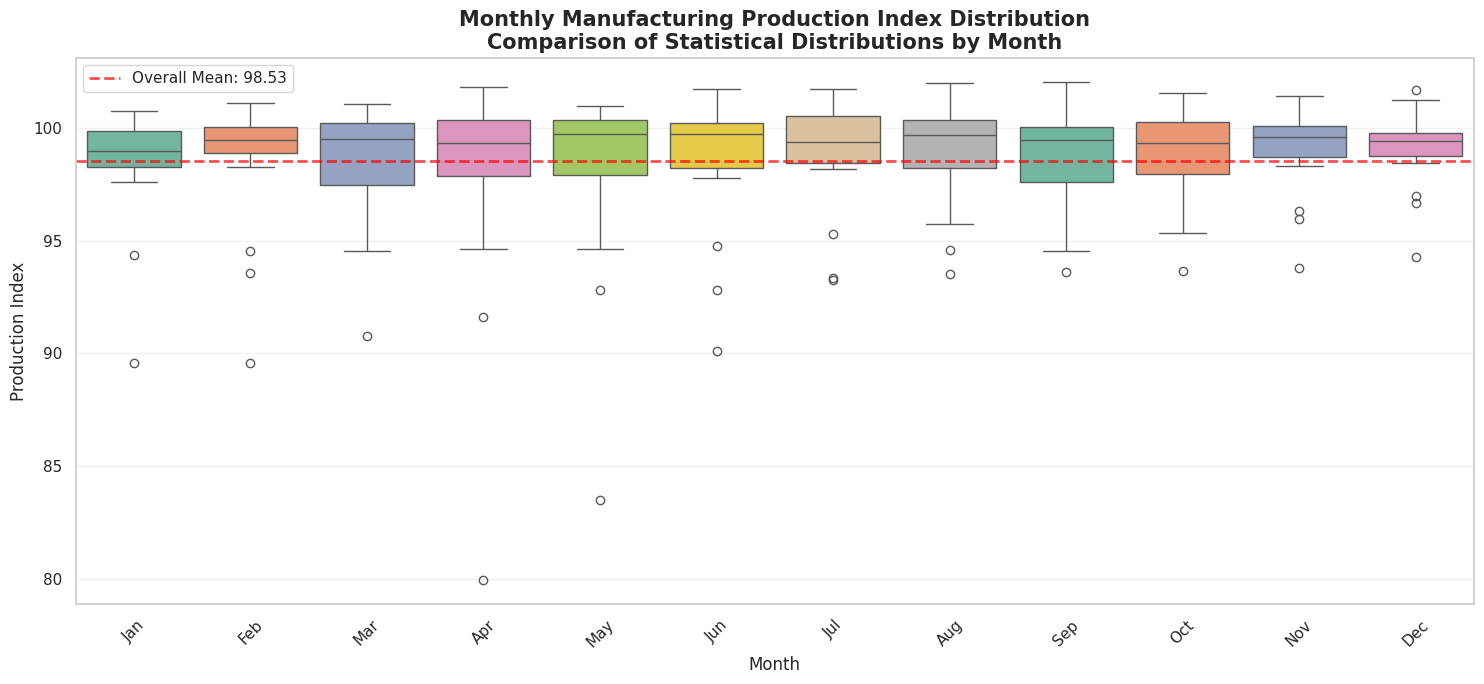

In [41]:
fig, ax = plt.subplots(figsize=(15, 7))

# 월 이름 매핑
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_name'] = df['month'].map(dict(zip(range(1, 13), month_names)))

# 월별 제조업 생산지수 박스플롯
sns.boxplot(data=df, x='month_name', y='manufacturing_index',
            palette='Set2', ax=ax)
ax.set_title('Monthly Manufacturing Production Index Distribution\nComparison of Statistical Distributions by Month',
             fontsize=15, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Production Index', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# 전체 평균선 (모든 월 평균 표시)
overall_mean = df['manufacturing_index'].mean()
ax.axhline(y=overall_mean, color='red', linestyle='--', linewidth=2,
           alpha=0.7, label=f'Overall Mean: {overall_mean:.2f}')
ax.legend(fontsize=11)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 히트맵 - 연도별 월별 패턴

**시각화 목적:**
- 시간의 흐름에 따른 계절 패턴 변화 확인
- 특정 연도/월의 이상값 파악
- 장기 추세와 계절성의 결합 효과 관찰

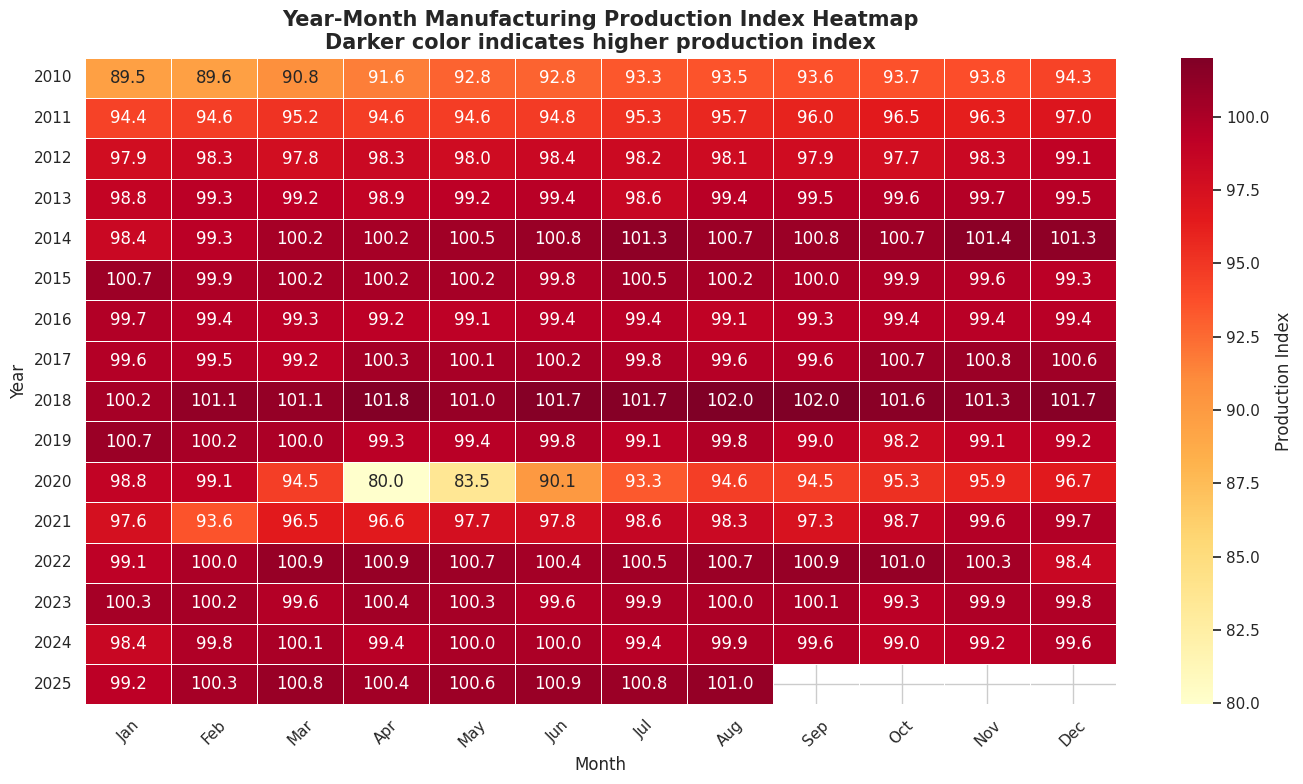

In [42]:
pivot_data = df.pivot_table(values='manufacturing_index',
                            index='year',
                            columns='month',
                            aggfunc='mean')

fig, ax = plt.subplots(figsize=(14, 8))

# 연도별-월별 제조업 생산지수 히트맵
sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': 'Production Index'}, ax=ax, linewidths=0.5)

ax.set_title('Year-Month Manufacturing Production Index Heatmap\nDarker color indicates higher production index',
             fontsize=15, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Year', fontsize=12)
ax.set_xticklabels(month_names, rotation=45)

plt.tight_layout()
plt.show()